## Lotka-Volterra Model (Prey-Predator-Model)

du/dt = au - buv

dv/dt = -cv + dbu*v

with the following notations:

    u: number of preys (for example, rabbits)

    v: number of predators (for example, foxes)

    a, b, c, d are constant parameters defining the behavior of the population:

        a is the natural growing rate of rabbits, when there's no fox

        b is the natural dying rate of rabbits, due to predation

        c is the natural dying rate of fox, when there's no rabbit

        d is the factor describing how many caught rabbits let create a new fox

1. the code is from
https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html#

## definition of the equation

In [ ]:
#!python
from numpy import *
import pylab as p
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75
def dX_dt(X, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    return array([ a*X[0] -   b*X[0]*X[1] ,
                  -c*X[1] + d*b*X[0]*X[1] ])

### Population equilibrium

In [ ]:
#!python
X_f0 = array([     0. ,  0.])
X_f1 = array([ c/(d*b), a/b])
all(dX_dt(X_f0) == zeros(2) ) and all(dX_dt(X_f1) == zeros(2)) # => True

### Stability of the fixed points

In [ ]:
#!python
def d2X_dt2(X, t=0):
    """ Return the Jacobian matrix evaluated in X. """
    return array([[a -b*X[1],   -b*X[0]     ],
                  [b*d*X[1] ,   -c +b*d*X[0]] ])


In [ ]:
#! python
A_f0 = d2X_dt2(X_f0)                    # >>> array([[ 1. , -0. ],
                                        #            [ 0. , -1.5]])

In [ ]:
#!python
A_f1 = d2X_dt2(X_f1)                    # >>> array([[ 0.  , -2.  ],
                                        #            [ 0.75,  0.  ]])
# whose eigenvalues are +/- sqrt(c*a).j:
lambda1, lambda2 = linalg.eigvals(A_f1) # >>> (1.22474j, -1.22474j)
# They are imaginary numbers. The fox and rabbit populations are periodic as follows from further
# analysis. Their period is given by:
T_f1 = 2*pi/abs(lambda1)                # >>> 5.130199



### Integrating the ODE using scipy.integrate

In [ ]:
#!python
from scipy import integrate
t = linspace(0, 15,  1000)              # time
X0 = array([10, 5])                     # initials conditions: 10 rabbits and 5 foxes
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'

In [ ]:
#!python
rabbits, foxes = X.T
f1 = p.figure()
p.plot(t, rabbits, 'r-', label='Rabbits')
p.plot(t, foxes  , 'b-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')
f1.savefig('rabbits_and_foxes_1.png')


### Plotting direction fields and trajectories in the phase plane

In [ ]:
values  = linspace(0.3, 0.9, 5)                          # position of X0 between X_f0 and X_f1
vcolors = p.cm.autumn_r(linspace(0.3, 1., len(values)))  # colors for each trajectory

f2 = p.figure()

#-------------------------------------------------------
# plot trajectories
for v, col in zip(values, vcolors):
    X0 = v * X_f1                               # starting point
    X = integrate.odeint( dX_dt, X0, t)         # we don't need infodict here
    p.plot( X[:,0], X[:,1], lw=3.5*v, color=col, label='X0=(%.f, %.f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = p.ylim(ymin=0)[1]                        # get axis limits
xmax = p.xlim(xmin=0)[1]
nb_points   = 20

x = linspace(0, xmax, nb_points)
y = linspace(0, ymax, nb_points)

X1 , Y1  = meshgrid(x, y)                       # create a grid
DX1, DY1 = dX_dt([X1, Y1])                      # compute growth rate on the gridt
M = (hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                 # Avoid zero division errors 
DX1 /= M                                        # Normalize each arrows
DY1 /= M

#-------------------------------------------------------
# Drow direction fields, using matplotlib 's quiver function
# I choose to plot normalized arrows and to use colors to give information on
# the growth speed
p.title('Trajectories and direction fields')
Q = p.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=p.cm.jet)
p.xlabel('Number of rabbits')
p.ylabel('Number of foxes')
p.legend()
p.grid()
p.xlim(0, xmax)
p.ylim(0, ymax)
f2.savefig('rabbits_and_foxes_2.png')

### Plotting contours

In [ ]:
#!python
def IF(X):
    u, v = X
    return u**(c/a) * v * exp( -(b/a)*(d*u+v) )
# We will verify that IF remains constant for different trajectories
for v in values:
    X0 = v * X_f1                               # starting point
    X = integrate.odeint( dX_dt, X0, t)
    I = IF(X.T)                                 # compute IF along the trajectory
    I_mean = I.mean()
    delta = 100 * (I.max()-I.min())/I_mean
    print('X0=(%2.f,%2.f) => I ~ %.1f |delta = %.3G %%' % (X0[0], X0[1], I_mean, delta))
# >>> X0=( 6, 3) => I ~ 20.8 |delta = 6.19E-05 %
#     X0=( 9, 4) => I ~ 39.4 |delta = 2.67E-05 %
#     X0=(12, 6) => I ~ 55.7 |delta = 1.82E-05 %
#     X0=(15, 8) => I ~ 66.8 |delta = 1.12E-05 %
#     X0=(18, 9) => I ~ 72.4 |delta = 4.68E-06 %


In [ ]:
#!python
#-------------------------------------------------------
# plot iso contours
nb_points = 80                              # grid size
x = linspace(0, xmax, nb_points)
y = linspace(0, ymax, nb_points)
X2 , Y2  = meshgrid(x, y)                   # create the grid
Z2 = IF([X2, Y2])                           # compute IF on each point
f3 = p.figure()
CS = p.contourf(X2, Y2, Z2, cmap=p.cm.Purples_r, alpha=0.5)
CS2 = p.contour(X2, Y2, Z2, colors='black', linewidths=2. )
p.clabel(CS2, inline=1, fontsize=16, fmt='%.f')
p.grid()
p.xlabel('Number of rabbits')
p.ylabel('Number of foxes')
p.ylim(1, ymax)
p.xlim(1, xmax)
p.title('IF contours')
f3.savefig('rabbits_and_foxes_3.png')
p.show()

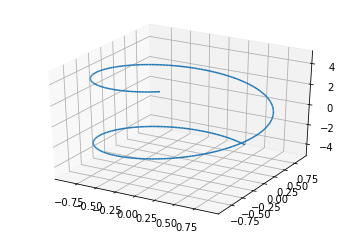

In [2]:
%matplotlib inline
from sympy import symbols, cos, sin
from sympy.plotting import plot3d_parametric_line
u = symbols('u')
plot3d_parametric_line(cos(u), sin(u), u, (u, -5, 5))